HPA_KF
33.49091759782629 35.04740624030279 40.46056860771653
HFA_KF_c0
34.97893601671025 37.7646833631913 44.47197887662611
HPA_YS
28.53955192097726 29.911916031492726 39.002673329460855
HFA_YS_c0
30.217519914834014 32.377975933695176 49.49342398916976


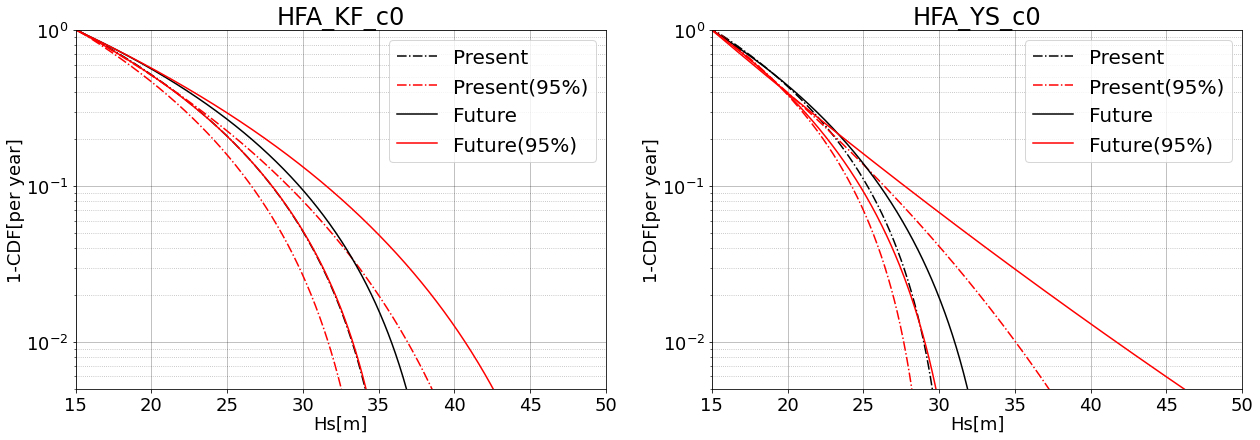

In [4]:
"""
LWMの出力結果を用いて, STMの極値増大確率を算出する.
"""

import func
from csv import reader
import matplotlib.pyplot as plt
import numpy as np

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    将来分布の中で, hsより大きい値を取る確率を合計する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def GP(xi, sgm, y):
    """
    GPの1-CDF
    """
    if y <= 0:
        return 1
    else:
        return max(0, (1 + xi * y / sgm)) ** (-1/xi)

# 描画用の画像を用意
fig = plt.figure(figsize=(18, 6))
MODEL = ['KF', 'YS']
for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'

        print(model)

        with open('../Ex_csv/' + model + '_STM.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            STM = list(csv_reader)
        
        POT_DATA = sorted([float(s[0]) for s in STM], reverse=True)
        u = POT_DATA[-1]
        if num == 0:
            past_rv, past_pro, p_xi, p_sgm = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=u, n=219143, n0=len(POT_DATA), con=0.95)
            u_p = u
        else:
            f_rv, f_pro, f_xi, f_sgm =  func.lwm_gpd(data=POT_DATA, error=[0.005], thr=u, n=219143, n0=len(POT_DATA), con=0.95)
            u_f = u
        
    # P = calc_p(past_rv, past_pro, f_rv, f_pro)
    # print(P, '%の確率で極値増加')
    ax = fig.add_subplot(1, 2, model_num + 1)
    # MLのplot
    x = np.linspace(1, 50, 1000)
    ax.plot(x, [GP(xi=p_xi[1], sgm=p_sgm[1], y=x_ - u_p) for x_ in x], color='black', linestyle="dashdot", label='Present')
    ax.plot(x, [GP(xi=p_xi[0], sgm=p_sgm[0], y=x_ - u_p) for x_ in x], color='red', linestyle="dashdot", label='Present' + '(95%)')
    ax.plot(x, [GP(xi=p_xi[2], sgm=p_sgm[2], y=x_ - u_p) for x_ in x], color='red', linestyle="dashdot")
    ax.plot(x, [GP(xi=f_xi[1], sgm=f_sgm[1], y=x_ - u_f) for x_ in x], color='black', label='Future')
    ax.plot(x, [GP(xi=f_xi[0], sgm=f_sgm[0], y=x_ - u_f) for x_ in x], color='red', label='Future' + '(95%)')
    ax.plot(x, [GP(xi=f_xi[2], sgm=f_sgm[2], y=x_ - u_f) for x_ in x], color='red')
    ax.legend(fontsize=20)
    ax.set_xlim((15, 50))
    ax.set_ylim((0.005, 1))
    ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
    ax.set_ylabel("1-CDF[per year]", fontsize=18, labelpad=1)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(model, fontsize=24)
    ax.set_yscale('log')
    ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
    ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)
fig.subplots_adjust(left=0.07, right=0.97, bottom=0.1, top=0.93) #この1行を入れる
plt.savefig('../img/stm_cdf.png')
plt.show()